[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Asterios7/torch_image_classifier/blob/main/notebooks/OxfordIIITPet_classification.ipynb)

#  Image Classification for OxfordIIITPet

In [2]:
# Install dependencies
!pip install torchmetrics torchinfo mlflow -q

In [ ]:
# Imports
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import  summary
from torchmetrics import Accuracy
from tqdm.auto import tqdm
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from PIL import  Image

# Get utility modules from github in they don't exist
try:
    from utilities.torchTrain import torchTrain
    from utilities.util_functions import plot_loss_curves, save_model, load_model
except:
    print("Getting utility modules from https://github.com/Asterios7/torch_image_classifier ")
    !git clone https://github.com/Asterios7/torch_image_classifier
    !mv torch_image_classifier/image_classifier .
    !rm -rf torch_image_classifier
    from image_classifier.torchClassifier import torchClassifier
    from image_classifier.util_functions import (plot_loss_curves,
                                                 save_model,
                                                 load_model,
                                                 create_effnetb0_model)

torch.__version__, torchvision.__version__

In [4]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Train an Image Classification model

### 1. Create data transforms
Create transform with normalization to match the data distribution of the EfficientNetB0

Alternative approach for getting transforms:
```
# 1. Setup pretrained EffNetB0 weights
effnetb0_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB0 transforms
effnetb0_transforms = effnetb2_weights.transforms()
```

In [5]:
# Create EffnetB0 model data transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense the transformation
    transforms.ToTensor()
    # normalize
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

### 2. Get the OxfordIIITPet dataset

In [ ]:
# Load train and test datasets
train_dataset = datasets.OxfordIIITPet(root="data",
                                       split="trainval",
                                       transform=train_transforms,
                                       download=True);

test_dataset = datasets.OxfordIIITPet(root="data",
                                     split="test",
                                     transform=test_transforms,
                                     download=True);

class_names = train_dataset.classes
class_names_idx = train_dataset.class_to_idx

In [7]:
# # Check for imbalance
# from collections import Counter

# targets = [train_dataset[i][1] for i in np.arange(0, len(train_dataset))]
# class_counts = Counter(targets)
# print(f"Class counts: {class_counts}")

#### Select a subset for experimentation
Use this block for initial experimentation to reduce training times
- Selects a subset of 3 classes to train
- When using this block, make sure you modify:
    - the classifier head below to 3 classes `out_features=3`
    - the accuracy function `num_classes`

In [8]:
# # Define a list of class indices you want to keep (0-based)
# selected_classes = [0, 1, 2]  # Select the first three classes

# # Filter the dataset to keep only the specified classes
# train_dataset = [item for item in train_dataset if item[1] in selected_classes]
# test_dataset = [item for item in train_dataset if item[1] in selected_classes]


In [9]:
print(f"Train dataset number of samples: {len(train_dataset)}")
print(f"Test dataset number of samples: {len(test_dataset)}")


Train dataset number of samples: 3680
Test dataset number of samples: 3669


### 3. Visualize images

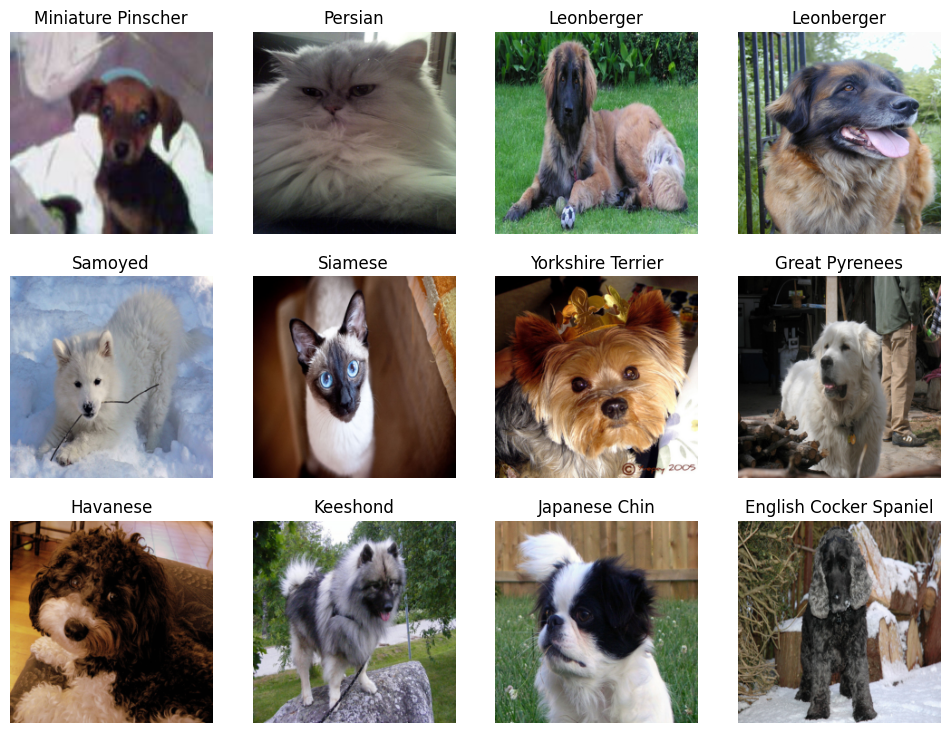

In [10]:
nrows = 3
ncols = 4

random.seed(13)
# Select random images from train dataset
random_images = []
random_labels = []
for idx in random.sample(list(np.arange(0, len(train_dataset))), k=nrows*ncols):
    random_images.append(train_dataset[idx][0])
    random_labels.append(train_dataset[idx][1])

# Plot random images with labels
plt.figure(figsize=(12, 9))

for i, sample_image in enumerate(random_images):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample_image.permute(1, 2, 0))
    plt.title(class_names[random_labels[i]])
    plt.axis(False)

### 4. Create Dataloaders

In [11]:
# Set batch_size and num_workers
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

# Print number of batches
print(f"Train DataLoader number of batches: {len(train_dataloader)}")
print(f"Test DataLoader number of batches: {len(test_dataloader)}")
print(f"Batch shape: {next(iter(train_dataloader))[0].shape}") # (batch_size, color_channels, height, width)

Train DataLoader number of batches: 115
Test DataLoader number of batches: 115
Batch shape: torch.Size([32, 3, 224, 224])


### 5. Create EfficientNet_B0 instance

In [12]:
# Get model weights
effnetb0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# Create a model instance
effnetb0 = torchvision.models.efficientnet_b0(weights=effnetb0_weights)
# Freeze the base layers in the mode0
for param in effnetb0.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 133MB/s] 


In [13]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

# Change the classifier layer (trainable)
effnetb0.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)

In [ ]:
from torchinfo import summary

summary(effnetb0,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

### 6. Train Model

In [15]:
# Select optimizer
optimizer = torch.optim.Adam(params=effnetb0.parameters(),
                             lr=1e-3)

# Set loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set accuracy function
accuracy_fn = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

# Instantiate torchTrain class
classifier = torchClassifier()

In [16]:
torch.manual_seed(13)
results = classifier.fit(model=effnetb0,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn,
                         epochs=5,
                         device=device)

2023/09/28 10:05:08 INFO mlflow.tracking.fluent: Experiment with name 'torch_classifier' does not exist. Creating a new experiment.


Epoch: 0 |Train loss: 2.1745 | Train acc: 0.5742 | Test loss: 1.1898 | Test acc: 0.7928
Epoch: 1 |Train loss: 0.9773 | Train acc: 0.8196 | Test loss: 0.8282 | Test acc: 0.8186
Epoch: 2 |Train loss: 0.6949 | Train acc: 0.8606 | Test loss: 0.7054 | Test acc: 0.8311
Epoch: 3 |Train loss: 0.5672 | Train acc: 0.8766 | Test loss: 0.6297 | Test acc: 0.8368


2023/09/28 10:08:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch: 4 |Train loss: 0.4784 | Train acc: 0.8997 | Test loss: 0.6013 | Test acc: 0.8379


2023/09/28 10:08:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpuurbnh_7/model/data, flavor: pytorch), fall back to return ['torch==2.0.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 7. Plot Loss & Accuracy Curves

In [17]:
plot_loss_curves(results)

### 8. Save model in `models` folder


In [18]:
today = date.today()
model_name = f"effnetb0_{today}_test-acc-{int(results['test_acc'][-1]*1e+4)}.pt"
save_model(model=effnetb0,
           target_dir='models',
           model_name=model_name)

[INFO] Saving model to: models/effnetb0_2023-09-28_test-acc-8379.pt


#### Zip and download mlruns
Download experiments to your machine. To view experiments with the mlflow ui locally in your machine do:

1. Open a terminal
2. If mlflow is not installed in your environment do `pip install mlflow`
3. Go to `my/local/path/to/mlruns`
4. Do `mlflow server --port 5000`
5. Open http://localhost:5000

In [ ]:
!zip -r ./mlruns.zip ./mlruns

In [22]:
from google.colab import files
files.download("mlruns.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Load the saved model and make predictions

### 1. Load saved model

In [23]:
# Create EffNet0 model instance with changed classifier head
effnetb0_loaded = create_effnetb0_model(num_classes=len(class_names))

# Load saved weights
model_path = f"./models/{model_name}"
effnetb0_loaded.load_state_dict(
    torch.load(f=model_path,
               map_location=torch.device(device)))

<All keys matched successfully>

### 2. Create data transform and make prediction

In [24]:
# Select image_path from downloaded data
image_path = "./data/oxford-iiit-pet/images/basset_hound_108.jpg"

# Create data transform for the image / Same as test_transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

pred_label, pred_prob = classifier.predict(model=effnetb0_loaded,
                                           image_path=image_path,
                                           class_names=class_names,
                                           image_size=(224, 224),
                                           transform=transform,
                                           device=device)

### 3. Plot prediction

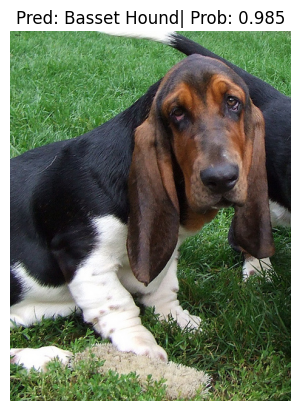

In [25]:
    img = Image.open(image_path)
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}| Prob: {pred_prob}")
    plt.axis(False);